# Sea ice concentration prediction using large scale modes of climate variability

* Can we relate large-scale climate modes/phenomena (e.g., NOA, CO2, AO, Nino3.4) to Arctic sea ice
* Arctic sea ice concentration (SIC) values range between 0 and 100, with land points represented by -1
* Prposed idea:
    * can we regress SIC from the climate modes?

## Plan

1. Data cleaning:
    - Formatting issues 
    - Duplicates
    - Missing values
    
2. Exploration
    - Looking for visual patterns (seasonality)
    
3. Feature engineering 
    - Adding features (e.g. seasonal, spatial)
    
3. Modeling 
    - Simple model - featureless: predict SIC has a weighted avg. of last 3 years same month.
    - Simple model II - Predict SIC using seasonal features.
    - Model with features (NOA, CO2, AO, Nino3.4) without time-series and run regression tree, random forest             regression, XGboost.
    - Add also seasonal features and run regression tree, random forest regression, XGboost.

4. Evaluation - Root mean squared error.

5. Insights ? 

### Import packages 

In [379]:
import sys
import time
import csv
from ggplot import *
import datetime 
import matplotlib.pyplot as plt
from sklearn import tree, ensemble
# installation: http://xarray.pydata.org/en/stable/installing.html
import xarray as xr
import cartopy 
import cartopy.crs as ccrs
from __future__ import division
import pandas as pd
import numpy as np

### Functions 

In [184]:
# read data for NOA, CO2, AO, Nino3.4
def read_data(url, phenom, reshape=True, use_cols=None, col_names=None):
    df = pd.read_csv(url, delim_whitespace=True, header=None, usecols=use_cols, names=col_names)
    df.rename(columns = {0: 'Year'}, inplace=True)
    if(reshape):
        df = reshape_col_month(df, phenom)
    else:
        pass
    df['Day'] = 15
    dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in df.iterrows() ]
    df['time'] = pd.DatetimeIndex(dt)
    df = df.drop(['Day'], axis=1)

    return df

In [11]:
def reshape_col_month(df, col_name):
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values: 
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [347]:
def weight_avg_same_mon_3yr(df):
    df['wheight_avg_same_mon_prev_3yr'] = (0.5 * df.groupby([df['Month']])['seaice_conc'].shift() +
                                           0.3 *(df.groupby([df['Month']])['seaice_conc'].shift(2)) +
                                           0.2*(df.groupby([df['Month']])['seaice_conc'].shift(3)))
        
    return df

In [345]:
def add_seasonal_feat(df):
    df['same_mon_prev_yr'] = df.groupby([df['Month']])['seaice_conc'].shift()
    df['prev_three_mon'] = df['seaice_conc'].shift().rolling(window=3).mean()
    df['prev_six_mon'] = df1['seaice_conc'].shift().rolling(window=6).mean()
    df['prev_yr'] = df1['seaice_conc'].shift().rolling(window=12).mean()
    df['wheight_avg_same_mon_prev_3yr'] = weight_avg_same_mon_3yr(df)
    
    return df

In [158]:
def rmse(x, y):
    loss = np.sqrt(np.mean((x - y) ** 2))
    return loss

In [339]:
def tr_te_split(X, Y, cond_df, cond):
        test_ind, train_ind = np.where(cond_df >= cond)[0], np.where(cond_df < cond)[0]
        X_train, X_test, Y_train, Y_test = X[train_ind,:], X[test_ind,:], \
                                                        Y[train_ind], Y[test_ind]
        return X_train, X_test, Y_train, Y_test

### Read data

In [216]:
'''make sure you have downloaded the data before - see Readme.md'''
nao = read_data('norm.nao.monthly.b5001.current.ascii.table.csv', 'NAO')
nino = read_data('nino34.long.anom.data.csv', 'NINO')
ao = read_data('ao.data.csv', 'AO')
co2 = read_data('co2_mm_mlo.csv', 'CO2', reshape=False, use_cols=[0, 1, 3], col_names=['Year', 'Month', 'CO2'])

## merge features
df = pd.merge(pd.merge(pd.merge(nino, nao), ao), co2)
## take data from 1979 onwrds to fit SIC data
df = df[df['Year'] > 1978]

# Sea ice concentration data
ds = xr.open_dataset('./G10010_SIBT1850_v1.1.nc')
sea_ice = ds.seaice_conc
sea_ice = sea_ice.sel(time=slice('1979-01-01', None)) # take slice over the satellite era only (1979-present)

### Data statistics - get sense what values we have

In [ ]:
df[['NINO', 'NAO', 'AO', 'CO2']].describe()

## Data cleaning

### Formatting 

In [ ]:
df.info()

In [211]:
sea_ice

<xarray.DataArray 'seaice_conc' (time: 420, latitude: 240, longitude: 1440)>
[145152000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.875 89.625 89.375 ... 30.625 30.375 30.125
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * time       (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2013-12-15
Attributes:
    short_name:     concentration
    long_name:      Sea_Ice_Concentration
    standard_name:  Sea_Ice_Concentration
    units:          Percent

In [ ]:
## All columns are in correct formats for my use.

### Duplicates
 - Do we have any duplicate dates ? 

In [ ]:
print('Are there duplicated dates in feature df ? /n ', any(df['datetime_col'].duplicated() == True))

In [ ]:
print('Are there duplicated dates in sic df ? /n ', any(sea_ice['time'].duplicated() == True))

### Missing vals
 - null/ na/ -1 for land points/ -99.99 for CO2

In [ ]:
### set missing values and create land-sea mask
mask = (sea_ice.isel(time=0).values == -1)
sea_ice.values[sea_ice.values == -1] = np.nan

### Work on a small slice of data
sea_ice_s = sea_ice.isel(latitude=slice(0, 150), longitude=slice(0, 200)) # TMP!!!

In [ ]:
### remove all nan values 
sea_ice_s = sea_ice_s.dropna()

In [18]:
print('How many CO2 missing values we have?', df[df['CO2']==-99.99].shape[0])

7

In [ ]:
# With one missing value with a distinctly different value than other CO2 values we can keep it in
# and let the tree handle it. We should also consider using R's implementation of using a surrogate for missing vals.

In [16]:
print('Are there null values in the feature df ? /n', sum(sum(np.array((pd.isnull(df)).astype(int)))) == 0)

0

In [ ]:
print('Are there na values in the feature df ? /n', sum(sum(np.array((pd.isna(df)).astype(int)))) == 0)

## Exploration 

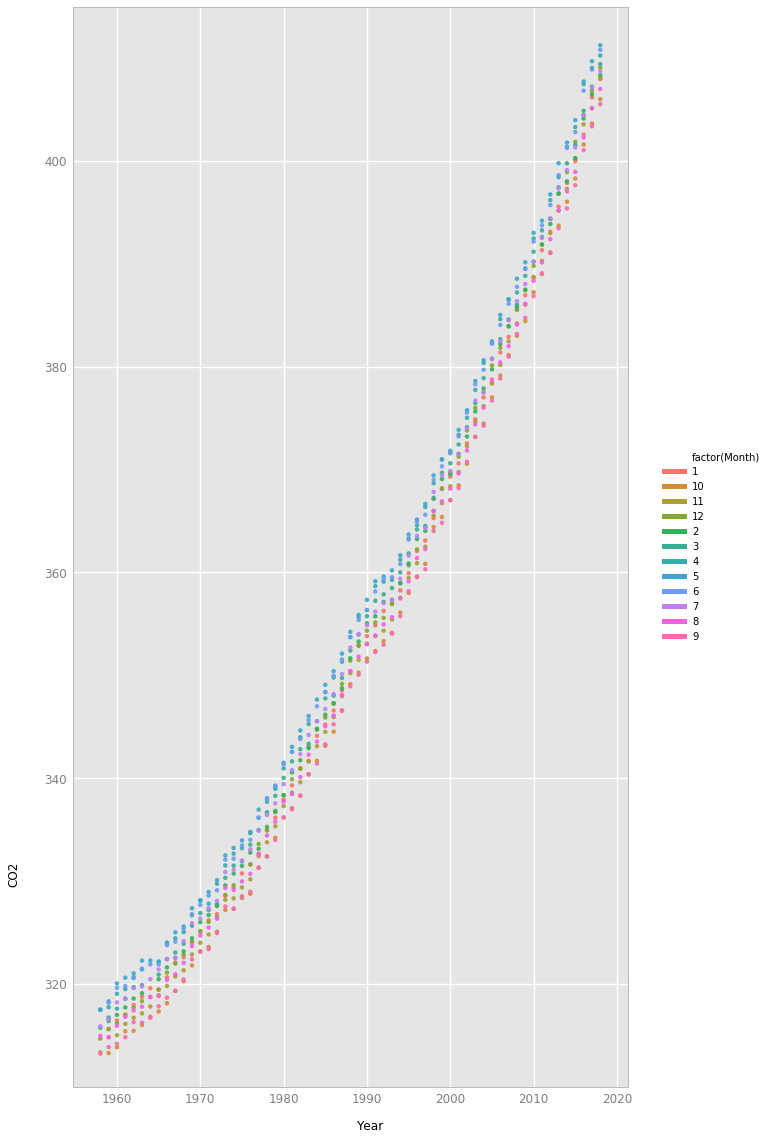

<ggplot: (7594656925)>

In [307]:
ggplot(aes(x='Year', y='CO2', colour='factor(Month)'), data=df) + geom_point( alpha = 0.9) + scale_y_discrete(limits =(310, 415))+ theme(plot_margin = dict(right = .3, top=2)) 

In [ ]:
# See http://mlg.eng.cam.ac.uk/carl/words/carbon.html for more details about CO2 growth rate.

In [334]:
p = ggplot(aes(x='Year', y='NINO'), data=df_filtered) + geom_point(aes(color = 'Month'), alpha = 0.9) 

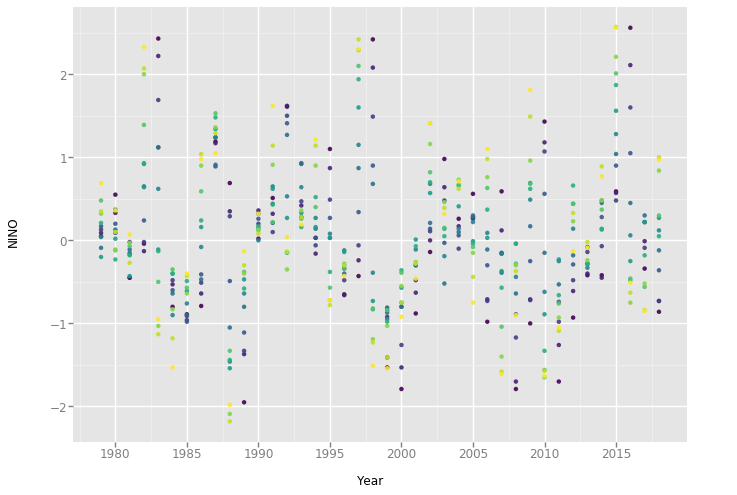

<ggplot: (7589479805)>

In [335]:
p

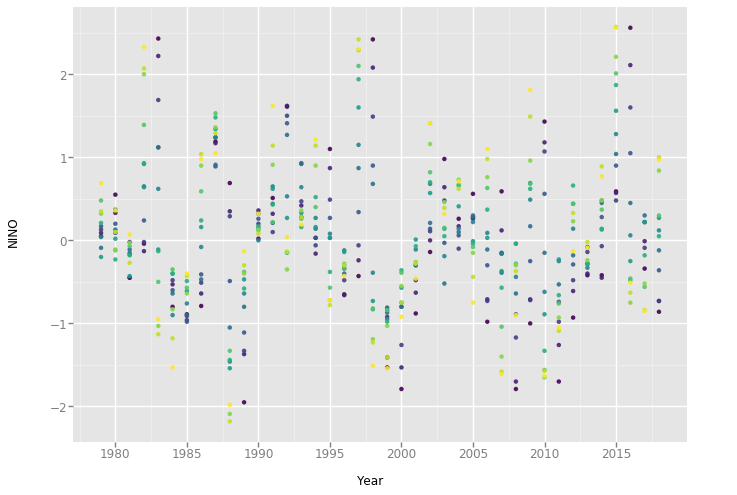

<ggplot: (7582917381)>

In [321]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
plt.subplot(1, 2, 1)
ggplot(aes(x='Year', y='AO'), data=df_filtered) + geom_point(aes(color = 'Month'), alpha = 0.9) + scale_y_discrete() 
plt.subplot(1, 2, 2)
ggplot(aes(x='Year', y='NAO'), data=df_filtered) + geom_point(aes(color = 'Month'), alpha = 0.9) 


ggplot(aes(x='(Month)', y='NAO'), data=df_filtered[(df_filtered['Year'] > 2000) & (df_filtered['Year'] < 2005)]) + geom_line() + facet_grid('Year')

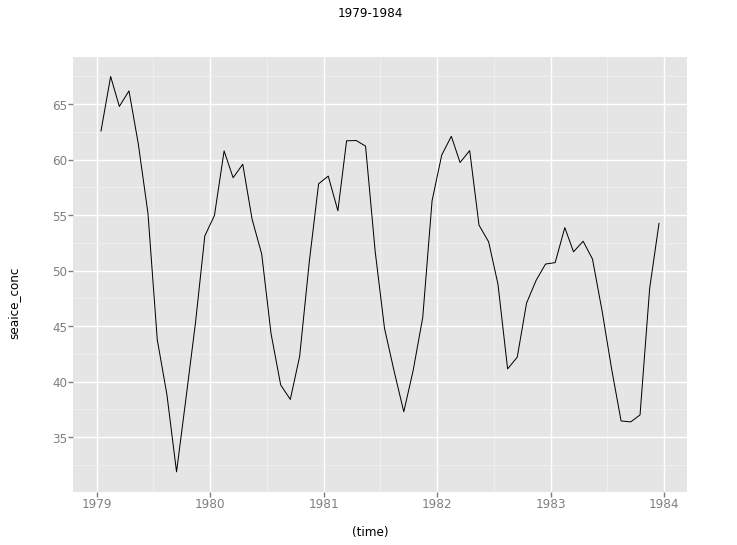

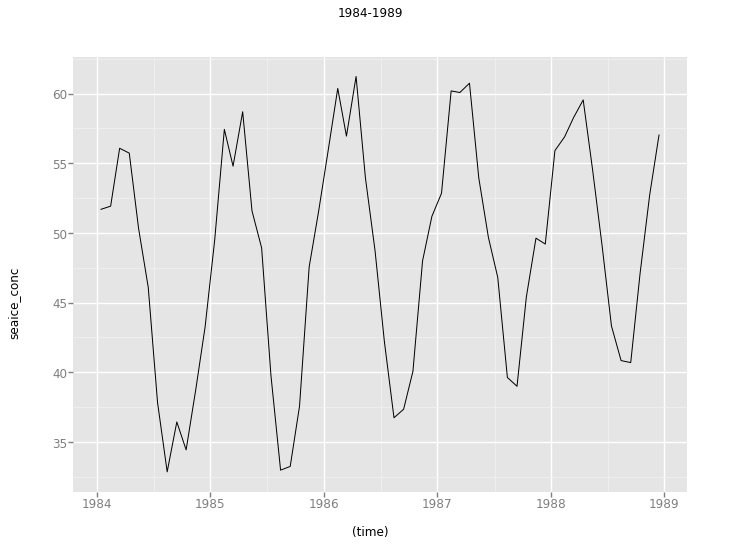

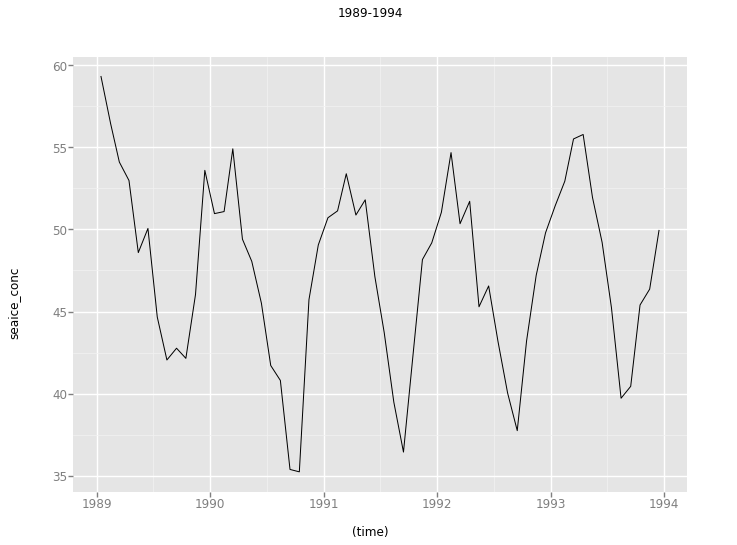

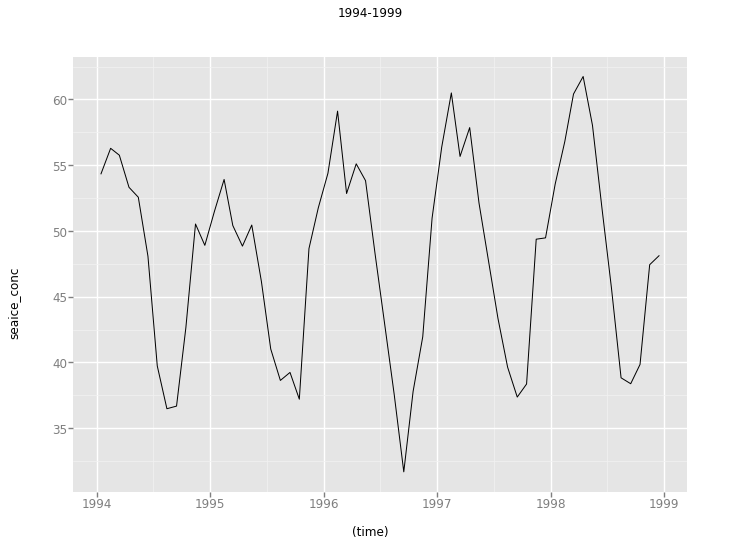

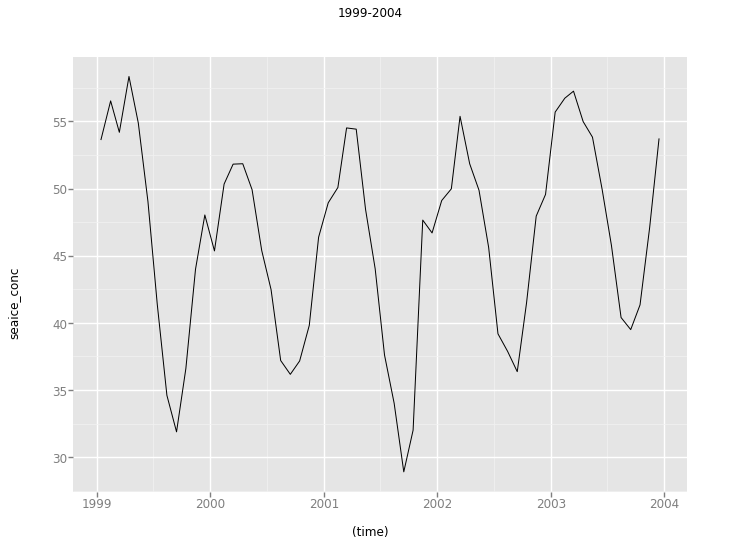

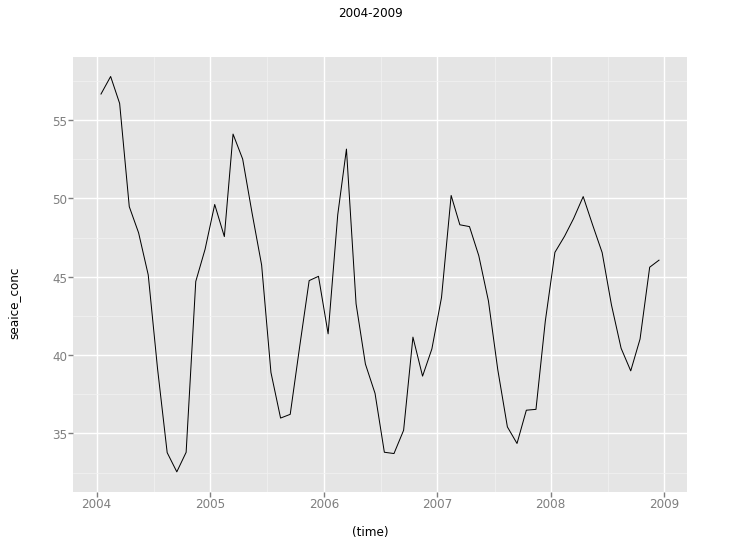

ValueError: num must be 1 <= num <= 6, not 7

In [131]:
count = 1
for yr in range(1979, 2013, 5):
    da9 = da1.sel(time=slice(str(yr) + '-01-01', str(yr + 5) +'-01-01'))
    dd = da9.to_dataframe().reset_index()
    dt = dd[dd['seaice_conc'] != -1]
    dt1 = dt[['time', 'seaice_conc']].groupby('time').mean().reset_index()
    plt.subplot(3, 3, count)
    p = ggplot(aes(x='(time)', y='seaice_conc'), data=dt1) + geom_line()  + ggtitle(str(yr) + '-' + str(yr + 5))
    p.show()
    count += 1

In [317]:
dd = da1.to_dataframe().reset_index()
dt = dd[dd['seaice_conc'] != -1]
dt1 = dt[['time', 'seaice_conc']].groupby('time').mean()
dt2 = dt1.reset_index()
dt2['MA'] = dt2['seaice_conc'].rolling(window=12).mean()

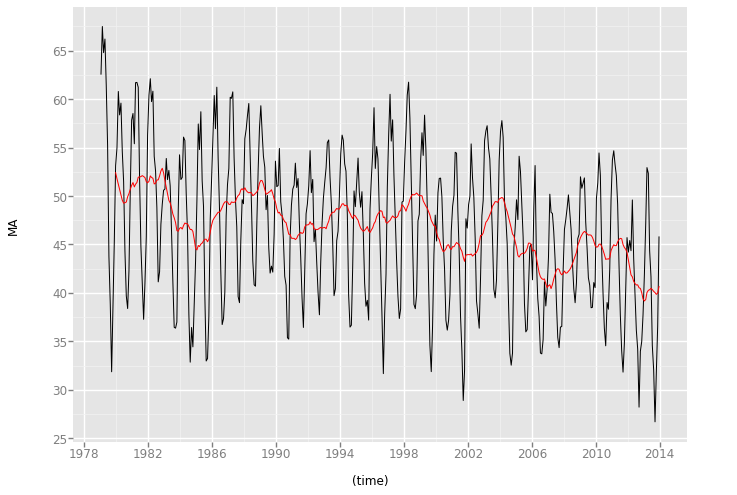

<ggplot: (7563570897)>

In [318]:
ggplot(aes(x='(time)', y='seaice_conc'), data=dt2) + geom_line() + geom_line(aes(y='MA', colour ='red')) 

In [43]:
# trend seems to go down in general 
# monthly trens seems similar in most years -> let's choose one year to look closer at the months :

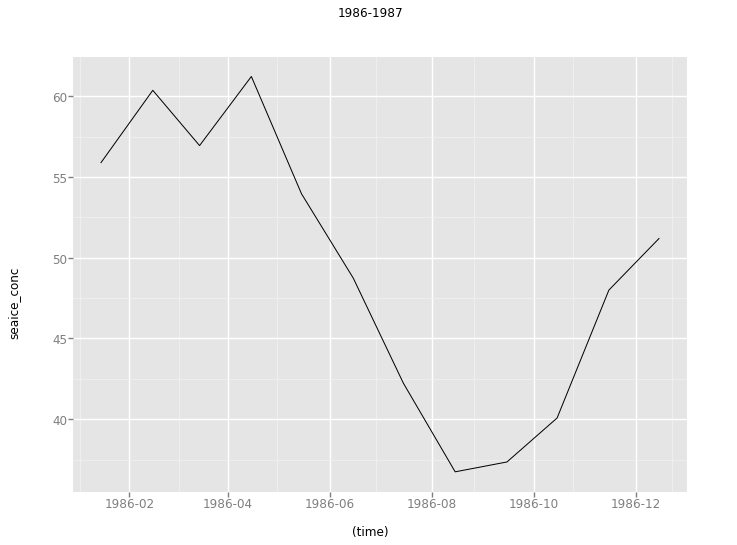

In [44]:
    da9 = da1.sel(time=slice('1986-01-01', '1987-01-01'))
    dd = da9.to_dataframe().reset_index()
    dt = dd[dd['seaice_conc'] != -1]
    dt1 = dt[['time', 'seaice_conc']].groupby('time').mean().reset_index()
    p = ggplot(aes(x='(time)', y='seaice_conc'), data=dt1) + geom_line()  + ggtitle('1986-1987')
    p.show()

In [45]:
# It seems that the seasonality follows the summertime (May-September -> reduction in sea ice concentration)
# Winter time (October - April -> increase in sea ice concentration).

In [46]:
# we would like to add the following seasonal features: 
# month indicator (one-hot) 
# same month last year value 
# weighted avg same month last 3 years value (0.5, 0.3, 0.2)
# last 3 months 
# last 6 months 
# last 12 months 

### Figures showing sea ice concentration and focus area (for modelling) respectively

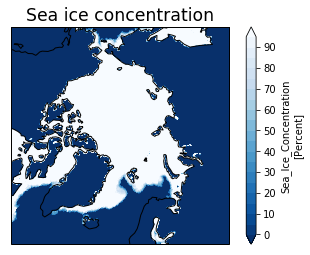

Text(0.5,1,u'0=ocean, 1=sea ice')

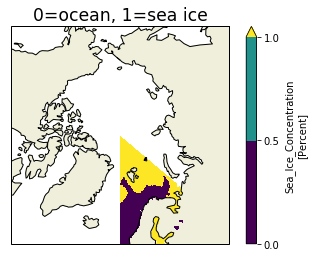

In [230]:
plt.subplot(1, 2, 1)
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
sea_ice.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=range(0,100,5),
                              cmap='Blues_r', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('Sea ice concentration', size='xx-large')
plt.show()

plt.subplot(1, 2, 2)
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
sea_ice.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=[0,0.5,1],
                              cmap='viridis', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('0=ocean, 1=sea ice', size='xx-large')

## Model
Why I chose the tree based models - see Readme.md file 

In [441]:
def train_test(feat_df, sic_df, model, ch_feat ,lon, lat):
## Uncomment to write to a file - adding long time to run
##     with open(model + '_.csv', 'wb') as csvfile:
##         wr = csv.writer(csvfile,  delimiter='\t',  lineterminator='\n')
##         wr.writerow(['Model', "tr_rmse", "te_rmse", "lat", "lon", "features", "feat_importance", "model_spec"])
        start = time.time()
        te_err = []; tr_err = []; count = 0 
        
        for i in range(0, nlons):
            for j in range(0, nlats):


                if mask[j, i] == False:

                    sic_filt = sic_df.isel(latitude = j, longitude = i).to_dataframe().reset_index()
                    ## if all vals are equal the tree is meaningless
                    if (np.all(sic_filt['seaice_conc'] == sic_filt['seaice_conc'][1])):
                        break
                    df1  = pd.merge(feat_df, sic_filt)
                    df1 = add_seasonal_feat(df1)

                    # ensure no nan values
                    df1 = df1[df1['Year'] > 1982]
                    
                    X   = df1[ch_feat].values
                    Y   = df1['seaice_conc'].values
                    yrs = df1['Year'].values
                    ### Split data into training and testing datasets
                    X_train, X_test, Y_train, Y_test = tr_te_split(X, Y, yrs, 2010)
                    
                    
                    # Set all slots to -1 and update them in prediction section below
                    if count == 0:
                        Y_pred_3d = np.ones( (Y_test.shape[0], nlats, nlons) ) * -1
                        Y_test_3d = np.ones( (Y_test.shape[0], nlats, nlons) ) * -1
                        
                    Y_test_3d[:, j, i] = Y_test                    
                    #####################
                    ### Regressor model
                    #####################
                    if(model == 'simple'):
                        Y_pred_3d[:, j, i] = X_test[:, -1]
                        predicted = X_test[:, -1]
                        curr_tr_err = 'None'; clf = 'None'; important ='None';
                    else:
                        if(model == 'tree'):
                            clf = tree.DecisionTreeRegressor()
                        elif(model == 'random_for'):
                            clf = ensemble.RandomForestRegressor()
                        else:
                            clf = ensemble.GradientBoostingRegressor()
                        clf = clf.fit(X_train, Y_train)
                        # Prediction 
                        Y_pred_3d[:, j, i] = clf.predict(X_test)
                        predicted = clf.predict(X_test)
                        # Loss calculation
                        curr_tr_err = rmse(Y_train, clf.predict(X_train))
                        important = clf.feature_importances_
                    
                    curr_te_err = rmse(Y_test, predicted)
                    te_err.append(curr_te_err); tr_err.append(curr_tr_err)
                    # Write to file - uncomment - this will add a lot of time to the run
                    # wr.writerow([model, curr_tr_err, curr_te_err, j, i, ch_feat, important, str(clf)])
                    count = count + 1

        end = time.time()    
        print('Model:', model)
        print('Training took:' + str((end - start) / 60) + ' ' + 'minutes')
        print(str(clf).replace('\n','').replace(' ', ''))
        print('test error is:', np.mean(te_err))
        print('train error is:', np.mean(tr_err))
        return model, np.mean(tr_err), np.mean(te_err), str((end - start) / 60)   

In [442]:
feat_df = df; sic_df = sea_ice_s;

## Evaluation

In [443]:
def main():
    results = {'Model': [], 'tr error': [], 'te error': [], 'runtime': []}
    results_pd = pd.DataFrame(data = results)
    models = ['simple', 'tree', 'random_for', 'xgb']
    nlons = sea_ice_s.longitude.shape[0]; nlats = sea_ice_s.latitude.shape[0]
    ch_feat = {'simple': ['wheight_avg_same_mon_prev_3yr'], 
               'seas_only': ['Month', 'same_mon_prev_yr', 'prev_three_mon', 'prev_six_mon', 'prev_yr', 'wheight_avg_same_mon_prev_3yr'], 
               'modes_only':  ['NAO', 'NINO','AO', 'CO2'],
               'alll': ['Month', 'NAO', 'NINO','AO', 'CO2', 'same_mon_prev_yr', 'prev_three_mon', 'prev_six_mon', 'prev_yr', 'wheight_avg_same_mon_prev_3yr']}
    
    for model in models:
        for feat in ch_feat:
            if(model == 'simple'):
                seasonal = False
        
            model, tr_err, te_err, runtime = train_test(feat_df, sic_df, model, ch_feat[feat], nlons, nlats)
            
            results_pd.append([model, tr_err, te_err, runtime])
            
            if(model == 'simple'):
                break
    return results_pd

In [444]:
main()

KeyboardInterrupt: 

In [453]:
model = 'tree'

In [454]:
ch_feat = ['Month', 'same_mon_prev_yr', 'prev_three_mon', 'prev_six_mon', 'prev_yr', 'wheight_avg_same_mon_prev_3yr']

In [449]:
nlons = sea_ice_s.longitude.shape[0]; nlats = sea_ice_s.latitude.shape[0]

In [ ]:
start = time.time()
te_err = []; tr_err = []; count = 0 

for i in range(0, nlons):
    print (i)
    for j in range(0, nlats):


        if mask[j, i] == False:

            sic_filt = sic_df.isel(latitude = j, longitude = i).to_dataframe().reset_index()
            ## if all vals are equal the tree is meaningless
    #             if (np.all(sic_filt['seaice_conc'] == sic_filt['seaice_conc'][1])):
    #                 break
            df1  = pd.merge(feat_df, sic_filt)
            df1 = add_seasonal_feat(df1)

            # ensure no nan values
            df1 = df1[df1['Year'] > 1982]

            X   = df1[ch_feat].values
            Y   = df1['seaice_conc'].values
            yrs = df1['Year'].values
            ### Split data into training and testing datasets
            X_train, X_test, Y_train, Y_test = tr_te_split(X, Y, yrs, 2010)


            # Set all slots to -1 and update them in prediction section below
            if count == 0:
                Y_pred_3d = np.ones( (Y_test.shape[0], nlats, nlons) ) * -1
                Y_test_3d = np.ones( (Y_test.shape[0], nlats, nlons) ) * -1

            Y_test_3d[:, j, i] = Y_test                    
            #####################
            ### Regressor model
            #####################
    #             if(model == 'simple'):
    #                 Y_pred_3d[:, j, i] = X_test[:, -1]
    #                 predicted = X_test[:, -1]
    #                 curr_tr_err = 'None'; clf = 'None'; important ='None';
    #             else:
    #                 if(model == 'tree'):
    #                     clf = tree.DecisionTreeRegressor()
    #                 elif(model == 'random_for'):
    #                     clf = ensemble.RandomForestRegressor()
    #                 else:
            clf = ensemble.GradientBoostingRegressor()
            clf = clf.fit(X_train, Y_train)
            # Prediction 
            Y_pred_3d[:, j, i] = clf.predict(X_test)
            predicted = clf.predict(X_test)
            # Loss calculation
            curr_tr_err = rmse(Y_train, clf.predict(X_train))
            important = clf.feature_importances_

            curr_te_err = rmse(Y_test, predicted)
            te_err.append(curr_te_err); tr_err.append(curr_tr_err)
            ## Write to file - uncomment - this will add a lot of time to the run
            # wr.writerow([model, curr_tr_err, curr_te_err, j, i, ch_feat, important, str(clf)])
            count = count + 1

end = time.time()    
print('Model:', model)
print('Training took:' + str((end - start) / 60) + ' ' + 'minutes')
print(str(clf).replace('\n','').replace(' ',''))
print('test error is:', np.mean(te_err))
print('train error is:', np.mean(tr_err))

0
